In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP
from preprocess_data import recode_variables, split_train_cal_test

In [157]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
df = pd.read_csv(f_path, na_values="None")
df = df.replace(to_replace=' ', value=np.nan)
df['Education'] = df['Education'].astype(float)
df = recode_variables(df)

In [158]:
df.drop(df[df['Female'] == 0].index, inplace=True)
df.dropna(inplace=True)

ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']

X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]

outcome = 'Waist'
y = df[[outcome]]
y = y[outcome].astype(float)

In [159]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.1
reg = CP(X_train, X_cal, y_train, y_cal)
reg.train(alpha=alpha)
scores = reg.calculate_scores()
qhat = reg.calc_qhat(alpha=alpha)

Fitting lower quantile (0.05)
Fitting upper quantile (0.95)
Fitting median quantile (0.5)
At alpha=0.1, qhat = 0.06535253042044076


In [160]:
test_pred_df = reg.predict_quantiles(X_test, y_test = y_test)
test_no_cal_df = reg.conformalize_CIs(test_pred_df, qhat=0)
test_cp_df = reg.conformalize_CIs(test_pred_df)

Conformalizing with qhat=0
Conformalizing with qhat=0.06535253042044076


Predicted CIs (sorted by y_true)

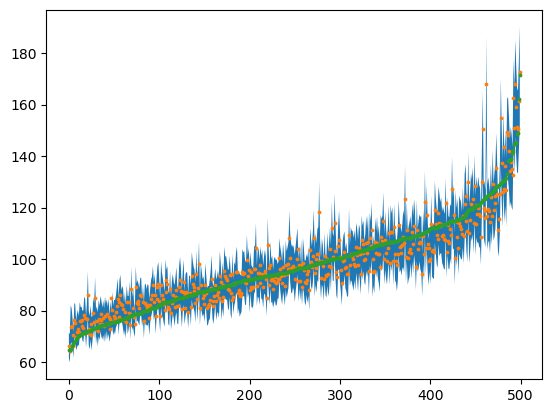

In [161]:
sample_df = test_cp_df.copy()
sample_df = sample_df.sample(n = 500)
sample_df = sample_df.sort_values(by=['y_true'])
sample_df = sample_df.reset_index()
import matplotlib.pyplot as plt

plt.fill_between(sample_df.index, sample_df['y_lower'], sample_df['y_upper'])
plt.scatter(sample_df.index, sample_df['y_median'], s=3)
plt.scatter(sample_df.index, sample_df['y_true'], s=3)

Predicted CIs (sorted by y_median)

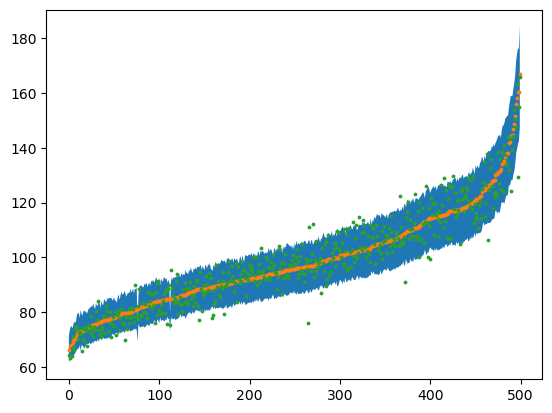

In [162]:
sample_df = test_cp_df.copy()
sample_df = sample_df.sample(n = 500)
sample_df = sample_df.sort_values(by=['y_median'])
sample_df = sample_df.reset_index()
import matplotlib.pyplot as plt

plt.fill_between(sample_df.index, sample_df['y_lower'], sample_df['y_upper'])
plt.scatter(sample_df.index, sample_df['y_median'], s=3)
plt.scatter(sample_df.index, sample_df['y_true'], s=3)

Coverage by difference size

Range 6.995431508840426 to 14.429950192622755: 0.8846549948506695
Range 14.436185002589411 to 16.527824154935686: 0.9001029866117405
Range 16.529061110391325 to 18.67771553902608: 0.9052523171987642
Range 18.68651837212917 to 21.53337837747273: 0.9196704428424305
Range 21.547644961360632 to 46.97740599861294: 0.8958762886597939


/Users/carlharris/anaconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


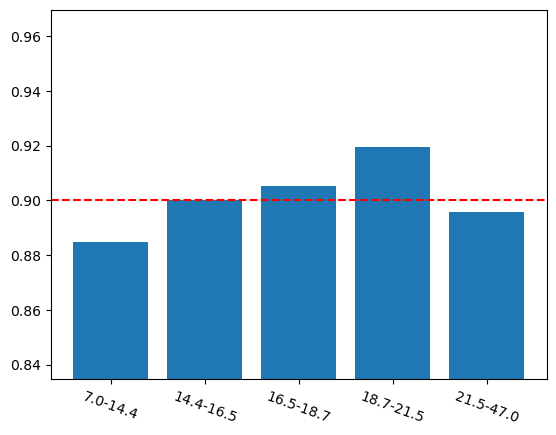

In [163]:
test_cp_df_tmp = test_cp_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["diff"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

x_labels = []
coverages = []
for i, split_df in enumerate(dfs):
    min_max = (split_df['diff'].iloc[0], split_df['diff'].iloc[-1])
    coverage = reg.calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage}")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-20)
plt.show()

Coverage by true WC

Range 61.1 to 82.7: 0.8578784757981462 (avg diff = 13.598711186251423)
Range 82.7 to 92.0: 0.9433573635427395 (avg diff = 15.6662267211558)
Range 92.0 to 100.2: 0.9299691040164778 (avg diff = 17.649246948158854)
Range 100.3 to 111.5: 0.9052523171987642 (avg diff = 19.694075053989913)
Range 111.5 to 176.7: 0.8690721649484536 (avg diff = 24.555905429866044)


/Users/carlharris/anaconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


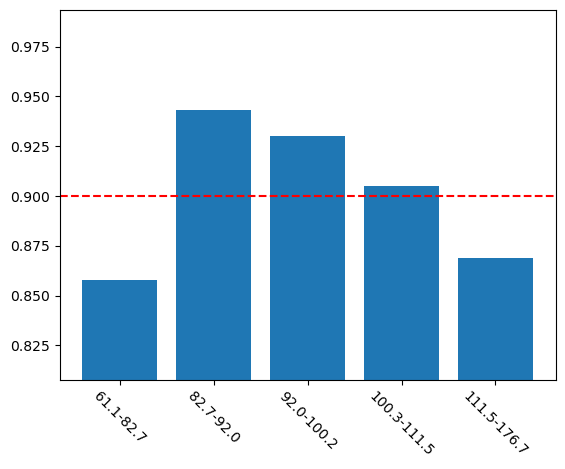

In [164]:
test_cp_df_tmp = test_cp_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["y_true"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

x_labels = []
coverages = []
for split_df in dfs:
    min_max = (split_df['y_true'].iloc[0], split_df['y_true'].iloc[-1])
    coverage = reg.calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage} (avg diff = {np.mean(split_df['diff'])})")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))
    
plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.show()

Coverage by ethnicity

Eth_Mex_Am: 0.8890322580645161
Eth_Oth_Hisp: 0.8947368421052632
Eth_Nonhisp_White: 0.9084468664850136
Eth_Nonhisp_Black: 0.9105485232067511
Eth_Other: 0.8785578747628083


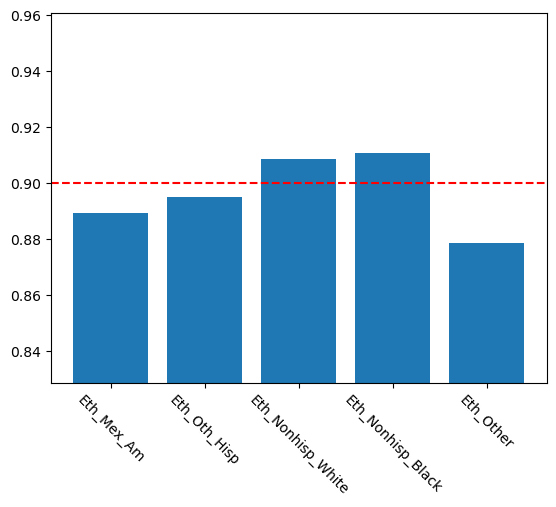

In [165]:
x_labels = []
coverages = []

for col in eth_dummies:
    y_col = test_cp_df[X_test[col] == 1]
    coverage = reg.calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(col)

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.show()

Coverage by education

Ed_less_9th: 0.8684807256235828
Ed_9th_11th: 0.917981072555205
Ed_HS_GED: 0.890279114533205
Ed_some_coll_AA: 0.9059987631416203
Ed_coll_above: 0.907871198568873
Ed_refused: 0.75
Ed_dk: 1.0


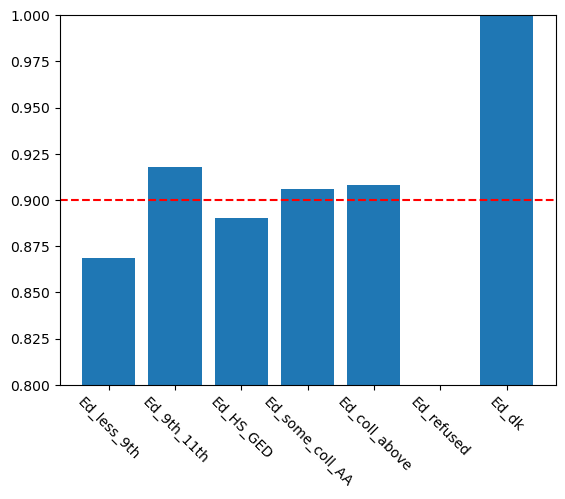

In [166]:
x_labels = []
coverages = []

for col in ed_dummies:
    y_col = test_cp_df[X_test[col] == 1]
    coverage = reg.calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(col)

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(1-2*alpha, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.show()

In [167]:
from sklearn.metrics import r2_score

r2 = r2_score(test_cp_df['y_true'], test_cp_df['y_lower'])
print(f"R2: {r2}")

r2 = r2_score(test_cp_df['y_true'], test_cp_df['y_upper'])
print(f"R2: {r2}")

r2 = r2_score(test_cp_df['y_true'], test_cp_df['y_median'])
print(f"R2: {r2}")

R2: 0.5761773998555053
R2: 0.5785522388904212
R2: 0.8853960725427487


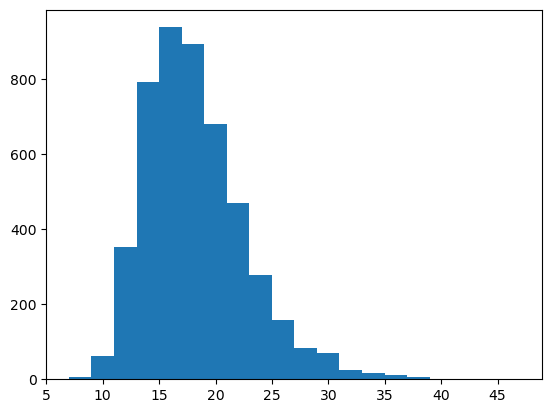

In [168]:
import matplotlib.pyplot as plt
plt.hist(test_cp_df['diff'], bins=20)
plt.show()

In [40]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_hat)
print(f"R2: {r2}")

R2: 0.8831603360851783
